<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu2/Minggu2_3Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 1.7 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt

#Load Dataset
---
Load both PDB1063 and UniSwiss dataset.

> df_pdb = pd.read_csv(pdb_dataset_path) <p> df_uni = pd.read_csv(uni_dataset_path) </p>




In [ ]:
df_pdb = pd.read_csv('/content/PDB1063-186.csv')
df_uni = pd.read_csv('/content/UniSwiss.csv')


print(f'Total sequence PDB: {len(df_pdb)}')
print(f'Total sequence UniSwiss: {len(df_uni)}')

Total sequence PDB: 1249
Total sequence UniSwiss: 9762


#Preprocess Dataset
---
Cleaning duplicate sequence (cleaning_dataset)

> df_clean = df.drop_duplicates(subset='sequence')

Split test and train dataset (split_dataset)


> train_df = df[df['set'] == 'train'] <p>
        test_df = df[df['set'] == 'test']




In [ ]:
def cleaning_dataset (df, dataset_name= None):
    if df is None or df.empty:
        print(f'Dataset {dataset_name} is empty. No clean required')
        return df

    df_clean = df.drop_duplicates(subset='sequence')

    print(f'Total protein dataset {dataset_name} after cleaning: {len(df_clean)}')

    return df_clean

df_pdb = cleaning_dataset(df_pdb, "PDB")
df_uni = cleaning_dataset(df_uni, "UniSwiss")


def split_dataset (df, dataset_name= None):
    if 'set' in df.columns:
        train_df = df[df['set'] == 'train']
        test_df = df[df['set'] == 'test']
    else:
        return df

    # Extract seq and labels for both dataset
    x_train = train_df['sequence'].tolist()
    y_train = train_df['label'].values

    x_test = test_df['sequence'].tolist()
    y_test = test_df['label'].values

    print(f"\nTraining sequence {dataset_name}: {len(x_train)}")
    print(f"Training label {dataset_name}: {len(y_train)}")

    print(f"Test sequence {dataset_name}: {len(x_test)}")
    print(f"Test label {dataset_name}: {len(y_test)}")

    return train_df, test_df, x_train, y_train, x_test, y_test

df_pdb_train, df_pdb_test, x_pdb_train, y_pdb_train, x_pdb_test, y_pdb_test = split_dataset(df_pdb, 'PDB')
df_uni_train, df_uni_test, x_uni_train, y_uni_train, x_uni_test, y_uni_test = split_dataset(df_uni, 'UniSwiss')


Total protein dataset PDB after cleaning: 1171
Total protein dataset UniSwiss after cleaning: 9696

Training sequence PDB: 1060
Training label PDB: 1060
Test sequence PDB: 111
Test label PDB: 111

Training sequence UniSwiss: 8940
Training label UniSwiss: 8940
Test sequence UniSwiss: 756
Test label UniSwiss: 756


#Load pretrain model

---


Check device processor for running
>device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load model ESM-1b
> model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

call converter/formatter for raw protein sequence into format can be processed by model
> batch_converter = alphabet.get_batch_converter()




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model = model.eval().to(device)

Using device: cpu
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


#Sequence Handling

---


Add window sliding for split long protein sequence into overlapping windows. (window_sliding)

If protein sequence length > 1022, split into overlap window (chunks)

In [ ]:
def window_sliding(seq, max_len=1022, stride=512):
    if len(seq) <= max_len:
        return [seq]
    chunks = []
    for i in range(0, len(seq), stride):
        chunk = seq[i:i + max_len]
        if len(chunk) < 50:   # skip fragments too short to be meaningful
            continue
        chunks.append(chunk)
    return chunks

#Embeddings

---
Extract mean ESM-1b embeddings for a list of protein sequences (extract_esm_embeddings).

In [ ]:
def extract_esm_embeddings(sequences, batch_size=8):
    """Extract mean ESM-1b embeddings with automatic windowing for long proteins."""
    all_embeddings = []
    truncated_count = 0

    for seq in tqdm(sequences, desc="Extracting ESM embeddings"):
        subseqs = window_sliding(seq)
        if len(seq) > 1022 :
            truncated_count += 1

        subseq_embeddings = []
        for i in range(0, len(subseqs), batch_size):
            batch = subseqs[i:i + batch_size]
            batch_data = [("", s) for s in batch]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)

            with torch.no_grad():
                results = model(batch_tokens, repr_layers=[33])
                reps = results["representations"][33]

            for j, s in enumerate(batch):
                emb = reps[j, 1:len(s)+1].mean(0).cpu().numpy()
                subseq_embeddings.append(emb)

            del batch_tokens, results, reps
            torch.cuda.empty_cache()

        # Average all windows for this protein
        mean_embedding = np.mean(subseq_embeddings, axis=0)
        all_embeddings.append(mean_embedding)

    print(f"Total sequences processed: {len(sequences)}")
    print(f"Sequences truncated (>1022 aa): {truncated_count} ({truncated_count/len(sequences)*100:.2f}%)")

    return np.vstack(all_embeddings)

x_pdb_train_emb = extract_esm_embeddings(x_pdb_train, batch_size=8)
x_pdb_test_emb  = extract_esm_embeddings(x_pdb_test, batch_size=8)

x_uni_train_emb = extract_esm_embeddings(x_uni_train, batch_size=8)
x_uni_test_emb  = extract_esm_embeddings(x_uni_test, batch_size=8)

Extracting ESM embeddings: 100%|██████████| 1060/1060 [02:11<00:00,  8.04it/s]


Total sequences processed: 1060
Sequences truncated (>1022 aa): 7 (0.66%)


Extracting ESM embeddings: 100%|██████████| 111/111 [00:17<00:00,  6.25it/s]


Total sequences processed: 111
Sequences truncated (>1022 aa): 2 (1.80%)


Extracting ESM embeddings: 100%|██████████| 8940/8940 [47:04<00:00,  3.17it/s]


Total sequences processed: 8940
Sequences truncated (>1022 aa): 735 (8.22%)


Extracting ESM embeddings: 100%|██████████| 756/756 [03:56<00:00,  3.20it/s]

Total sequences processed: 756
Sequences truncated (>1022 aa): 64 (8.47%)


#Checkpoints DL


---


Saving embedding output from pretrained model. <P>
Create directory for Deep Learning model
> os.makedirs("esm_embed/DL", exist_ok=True)

Save sequence train and test (PDB)
>torch.save(torch.tensor(x_pdb_train_emb), "esm_embed/DL/PDB/x_pdb_train.pt")<p>torch.save(torch.tensor(x_pdb_test_emb),  "esm_embed/DL/PDB/x__pdb_test.pt")

Save label train and test (PDB)
> np.save("esm_embed/DL/PDB/y_pdb_train.npy", y_pdb_train) <p>
np.save("esm_embed/DL/PDB/y_pdb_test.npy",  y_pdb_test)

In [ ]:
os.makedirs("esm_embed/DL", exist_ok=True)

torch.save(torch.tensor(x_pdb_train_emb), "esm_embed/DL/PDB/x_pdb_train.pt")
torch.save(torch.tensor(x_pdb_test_emb),  "esm_embed/DL/PDB/x_pdb_test.pt")

np.save("esm_embed/DL/PDB/y_pdb_train.npy", y_pdb_train)
np.save("esm_embed/DL/PDB/y_pdb_test.npy",  y_pdb_test)

torch.save(torch.tensor(x_uni_train_emb), "esm_embed/DL/UNI/x_uni_train.pt")
torch.save(torch.tensor(x_uni_test_emb),  "esm_embed/DL/UNI/x_uni_test.pt")

np.save("esm_embed/DL/UNI/y_uni_train.npy", y_uni_train)
np.save("esm_embed/DL/UNI/y_uni_test.npy",  y_uni_test)

print("Save success")

Save success


Feature selection for ML

In [ ]:
selector = SelectKBest(score_func=f_classif, k=512)  # reduce dimensionality
x_pdb_train_sel = selector.fit_transform(x_pdb_train_emb, y_pdb_train)
x_pdb_test_sel = selector.transform(x_pdb_test_emb)

print(f"Reduced from {x_pdb_train_emb.shape[1]} -> {x_pdb_train_sel.shape[1]} features.")

x_uni_train_sel = selector.fit_transform(x_uni_train_emb, y_uni_train)
x_uni_test_sel = selector.transform(x_uni_test_emb)

print(f"Reduced from {x_uni_train_emb.shape[1]} -> {x_uni_train_sel.shape[1]} features.")

Reduced from 1280 -> 512 features.
Reduced from 1280 -> 512 features.


Save sequence train and test for ML with featured selected

In [ ]:
os.makedirs("esm_embed/ML", exist_ok=True)

np.savez_compressed("esm_embed/ML/PDB/x_pdb_train_filtered.npz", x_pdb_train_sel)
np.savez_compressed("esm_embed/ML/PDB/x_pdb_test_filtered.npz",  x_pdb_test_sel)

np.save("esm_embed/ML/PDB/y_pdb_train.npy", y_pdb_train)
np.save("esm_embed/ML/PDB/y_pdb_test.npy",  y_pdb_test)

np.savez_compressed("esm_embed/ML/UNI/x_uni_train_filtered.npz", x_uni_train_sel)
np.savez_compressed("esm_embed/ML/UNI/x_uni_test_filtered.npz",  x_uni_test_sel)

np.save("esm_embed/ML/UNI/y_uni_train.npy", y_uni_train)
np.save("esm_embed/ML/UNI/y_uni_test.npy",  y_uni_test)

print("Save Success")

Save Success


#Load Checkpoints
Load embedding process for Deep learning and Machine learning

In [ ]:
# Deep learning
x_pdb_train_emb = torch.load("esm_embed/DL/PDB/x_pdb_train.pt").numpy()
y_pdb_train = np.load("esm_embed/DL/PDB/y_pdb_train.npy")

x_pdb_test_emb = torch.load("esm_embed/DL/PDB/x_pdb_test.pt").numpy()
y_pdb_test = np.load("esm_embed/DL/PDB/y_pdb_test.npy")

x_uni_train_emb = torch.load("esm_embed/DL/UNI/x_uni_train.pt").numpy()
y_uni_train = np.load("esm_embed/DL/UNI/y_uni_train.npy")

x_uni_test_emb = torch.load("esm_embed/DL/UNI/x_uni_test.pt").numpy()
y_uni_test = np.load("esm_embed/DL/UNI/y_uni_test.npy")

print ()

In [ ]:
# Machine learning
x_pdb_train_sel = np.load("esm_embed/ML/PDB/x_pdb_train_filtered.npz")['arr_0']
y_pdb_train = np.load("esm_embed/ML/PDB/y_pdb_train.npy")

x_pdb_test_sel = np.load("esm_embed/ML/PDB/x_pdb_test_filtered.npz")['arr_0']
y_pdb_test = np.load("esm_embed/ML/PDB/y_pdb_test.npy")

x_uni_train_sel = np.load("esm_embed/ML/UNI/x_uni_train_filtered.npz")['arr_0']
y_uni_train = np.load("esm_embed/ML/UNI/y_uni_train.npy")

x_uni_test_sel = np.load("esm_embed/ML/UNI/x_uni_test_filtered.npz")['arr_0']
y_uni_test = np.load("esm_embed/ML/UNI/y_uni_test.npy")

#Define Models
Define model with set hyperparamater/model architecture

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, n_classes):
        super(BiLSTMModel, self).__init__()
        # ARCHITECTURAL CHANGE POINT: Modify LSTM layers here
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # ARCHITECTURAL CHANGE POINT: Modify fully connected layers here
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x is expected to be (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x) # We only need lstm_out for the next layers
        # lstm_out is (batch_size, seq_len, hidden_dim * 2)
        # Since seq_len will be 1 for averaged embeddings, we squeeze it.
        x = lstm_out.squeeze(1) # Resulting in (batch_size, hidden_dim * 2)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        predictions = self.softmax(x)
        # Return both predictions and lstm_out (or any dummy) for compatibility with train_model
        return predictions, lstm_out

# Define the models
def define_model(model_type=None, input_dim=1280, hidden_dim=64, dropout=0.5, n_classes=2, embedding_dim=128, kernel_size=3, n_filters=64, nhead=4):
    if model_type == 'BiLSTM':
        # ARCHITECTURAL CHANGE POINT: Modify BiLSTM specific layers or add more here
        model = BiLSTMModel(input_dim, hidden_dim, dropout, n_classes)

    elif model_type == 'CNN':
        # ARCHITECTURAL CHANGE POINT: Modify Conv1d, Pooling, or Linear layers, add more blocks, etc.
        model = nn.Sequential(
            nn.Conv1d(1, n_filters, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(n_filters * (input_dim // 2), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
            nn.Softmax(dim=1)
        )

    elif model_type == 'Transformer':
        # ARCHITECTURAL CHANGE POINT: Modify TransformerEncoderLayer parameters, number of layers, add pre/post processing
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6) # num_layers can be changed

        model = nn.Sequential(
            transformer_encoder,
            nn.Flatten(start_dim=1),
            nn.Linear(input_dim, n_classes),
            nn.Softmax(dim=1)
        )

    elif model_type == 'MLP':
        # ARCHITECTURAL CHANGE POINT: Modify number of hidden layers, activation functions, dropout positions
        model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_classes),
            nn.Softmax(dim=1)
        )

    else:
        raise ValueError("Model type not recognized. Choose from ['BiLSTM', 'CNN', 'Transformer', 'MLP']")

    return model

#Train Models
Make sure select models you want to train by changing the model_type <p>List:
['BiLSTM', 'CNN', 'Transformer']
>trained_pdb_model = train_model(model_type='BiLSTM', train_data=x_pdb_train_emb, train_labels=y_pdb_train, test_data=x_pdb_test_emb, test_labels=y_pdb_test, epochs=50) <p>
trained_uni_model = train_model(model_type='BiLSTM', train_data=x_uni_train_emb, train_labels=y_uni_train, test_data=x_uni_test_emb, test_labels=y_uni_test, epochs=50)

Note: Do not run this code, unless you want train ML Model
>trained_pdb_model = train_model(model_type='MLP', train_data=x_pdb_train_sel, train_labels=y_pdb_train, test_data=x_pdb_train_sel, test_labels=y_pdb_test, epochs=50)
trained_uni_model = train_model(model_type='MLP', train_data=x_uni_train_sel, train_labels=y_uni_train, test_data=x_uni_train_sel, test_labels=y_uni_test, epochs=50)

In [ ]:
def train_model(model_type= None, train_data=None, train_labels=None, test_data=None, test_labels=None, batch_size=32, epochs=10, learning_rate=0.001, hidden_dim=64, dropout=0.5, n_filters=64, kernel_size=3, nhead=4):
    # Determine input_dim and n_classes dynamically from data
    input_dim = train_data.shape[1]
    n_classes = len(np.unique(train_labels))

    # Define the model, passing dynamic input_dim and n_classes, and other hyperparameters
    model = define_model(model_type=model_type, input_dim=input_dim, n_classes=n_classes,
                         hidden_dim=hidden_dim, dropout=dropout, n_filters=n_filters,
                         kernel_size=kernel_size, nhead=nhead)

    # Choose optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert data to tensors and move to device
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

    # Reshape data for BiLSTM, CNN, and Transformer input: add a sequence length dimension (N, D) -> (N, 1, D)
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        train_data_tensor = train_data_tensor.unsqueeze(1)
        test_data_tensor = test_data_tensor.unsqueeze(1)

    # Lists to store training history
    train_losses = []
    val_losses = [] # Added to store validation losses
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        if model_type == 'BiLSTM':
            outputs, _ = model(train_data_tensor)
        else:
            outputs = model(train_data_tensor)

        loss = criterion(outputs, train_labels_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluate on test set after each epoch
        model.eval()
        with torch.no_grad():
            if model_type == 'BiLSTM':
                test_outputs, _ = model(test_data_tensor)
            else:
                test_outputs = model(test_data_tensor)

            val_loss = criterion(test_outputs, test_labels_tensor) # Calculate validation loss
            val_losses.append(val_loss.item()) # Append validation loss

            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == test_labels_tensor).sum().item() / test_labels_tensor.size(0)
            test_accuracies.append(accuracy)

        # Print loss and accuracy
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%")

    # Final test accuracy print
    print(f"Final Test Accuracy: {test_accuracies[-1] * 100:.2f}%")
    return model, train_losses, val_losses, test_accuracies # Modified return statement

In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For all GPUs
    torch.cuda.manual_seed_all(seed) # For all GPUs

    # Ensures that CUDA operations are deterministic even if they might be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed} for reproducibility.")

# Call the function to set the seed
set_seed(42)

Random seed set to 42 for reproducibility.


Feel free do some experiment below with hyperparameter

In [ ]:
set_seed(42)

print("Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...")

trained_pdb_model, pdb_train_losses, pdb_val_losses, pdb_test_accuracies = train_model(
    model_type='BiLSTM', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_pdb_train_emb,
    train_labels=y_pdb_train,
    test_data=x_pdb_test_emb,
    test_labels=y_pdb_test,
    epochs=50,
    learning_rate=0.0005,
    hidden_dim=128, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

trained_uni_model, uni_train_losses, uni_val_losses, uni_test_accuracies = train_model(
    model_type='BiLSTM', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_uni_train_emb,
    train_labels=y_uni_train,
    test_data=x_uni_test_emb,
    test_labels=y_uni_test,
    epochs=50,
    learning_rate=0.0005,
    hidden_dim=128, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

Random seed set to 42 for reproducibility.
Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...
Epoch [10/50], Loss: 0.6687, Test Accuracy: 76.58%
Epoch [20/50], Loss: 0.5856, Test Accuracy: 72.97%
Epoch [30/50], Loss: 0.4860, Test Accuracy: 72.97%
Epoch [40/50], Loss: 0.4382, Test Accuracy: 74.77%
Epoch [50/50], Loss: 0.4118, Test Accuracy: 77.48%
Final Test Accuracy: 77.48%
Epoch [10/50], Loss: 0.6611, Test Accuracy: 68.65%
Epoch [20/50], Loss: 0.5872, Test Accuracy: 72.88%
Epoch [30/50], Loss: 0.5094, Test Accuracy: 80.29%
Epoch [40/50], Loss: 0.4530, Test Accuracy: 87.04%
Epoch [50/50], Loss: 0.4276, Test Accuracy: 88.62%
Final Test Accuracy: 88.62%


In [ ]:
# DO NOT RUN THIS CELL, UNLESS YOU WANT TRAIN ML MODEL!
set_seed(42)

trained_pdb_model_mlp, pdb_mlp_train_losses, pdb_mlp_val_losses, pdb_mlp_test_accuracies = train_model(
    model_type='MLP',
    train_data=x_pdb_train_sel,
    train_labels=y_pdb_train,
    test_data=x_pdb_test_sel,
    test_labels=y_pdb_test,
    epochs=50,
    learning_rate=0.0005,
    hidden_dim=128,
    dropout=0.3
)

trained_uni_model_mlp, uni_mlp_train_losses, uni_mlp_val_losses, uni_mlp_test_accuracies = train_model(
    model_type='MLP',
    train_data=x_uni_train_sel,
    train_labels=y_uni_train,
    test_data=x_uni_test_sel,
    test_labels=y_uni_test,
    epochs=50,
    learning_rate=0.0005,
    hidden_dim=128,
    dropout=0.3
)

Random seed set to 42 for reproducibility.
Epoch [10/50], Loss: 0.6542, Test Accuracy: 77.48%
Epoch [20/50], Loss: 0.5980, Test Accuracy: 72.97%
Epoch [30/50], Loss: 0.5498, Test Accuracy: 72.07%
Epoch [40/50], Loss: 0.5173, Test Accuracy: 72.07%
Epoch [50/50], Loss: 0.4943, Test Accuracy: 71.17%
Final Test Accuracy: 71.17%
Epoch [10/50], Loss: 0.6517, Test Accuracy: 71.83%
Epoch [20/50], Loss: 0.6062, Test Accuracy: 70.90%
Epoch [30/50], Loss: 0.5728, Test Accuracy: 74.34%
Epoch [40/50], Loss: 0.5470, Test Accuracy: 76.46%
Epoch [50/50], Loss: 0.5248, Test Accuracy: 78.57%
Final Test Accuracy: 78.57%


#Evaluate and Visualize
Evaluate model
>

Visualize histogram
>

Visualize Confusion Matrix
>

In [ ]:
def evaluate_model(model, X_test, y_test, model_type, dataset_name):
    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Reshape data for BiLSTM, CNN, and Transformer input if necessary
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    y_pred_probs = []
    y_preds = []

    with torch.no_grad():
        if model_type == 'BiLSTM':
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)

        y_pred_probs = outputs.cpu().numpy()
        _, predicted_labels = torch.max(outputs, 1)
        y_preds = predicted_labels.cpu().numpy()

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    mcc = matthews_corrcoef(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1]) # Assuming binary classification and prob of class 1

    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    specificity = tn / (tn + fp)

    metrics_dict = {
        "Model": model_type,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1": f1,
        "MCC": mcc,
        "ROC_AUC": roc_auc
    }

    print(f"\nEvaluation for {model_type} on {dataset_name} dataset:")
    print(f"Accuracy: {acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | ROC_AUC: {roc_auc:.3f}")

    return metrics_dict, y_preds, y_pred_probs

In [ ]:
# Function to visualize the confusion matrix and ROC curve
def visualize_metrics(y_true_pdb, y_pred_pdb, y_prob_pdb, y_true_uni, y_pred_uni, y_prob_uni, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true_pdb, y_pred_pdb, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true_uni, y_pred_uni, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_true_pdb, y_prob_pdb[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true_uni, y_prob_uni[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### Deep Learning Model Evaluation Example


Evaluation for BiLSTM on PDB dataset:
Accuracy: 0.775 | Precision: 0.405 | Recall: 0.833 | F1: 0.545 | ROC_AUC: 0.905

Evaluation for BiLSTM on UniSwiss dataset:
Accuracy: 0.886 | Precision: 0.885 | Recall: 0.885 | F1: 0.885 | ROC_AUC: 0.948


,Model,Dataset,Accuracy,Precision,Recall,Specificity,F1,MCC,ROC_AUC
0,BiLSTM,PDB,0.774775,0.405405,0.833333,0.763441,0.545455,0.466628,0.905018
1,BiLSTM,UniSwiss,0.886243,0.885333,0.885333,0.887139,0.885333,0.772472,0.947535


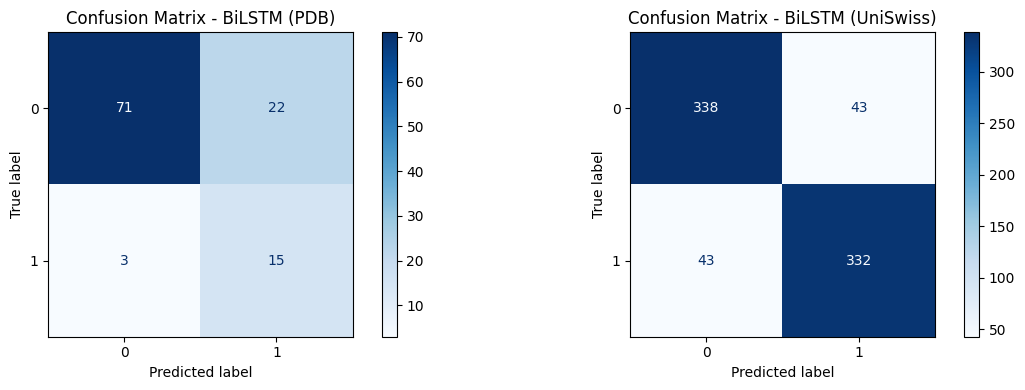

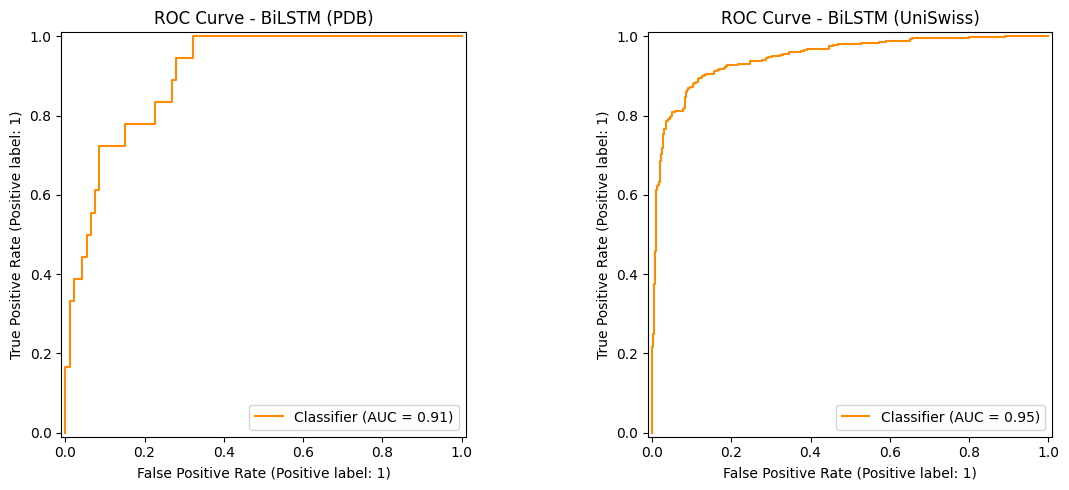

In [ ]:
# Assuming 'trained_pdb_model_exp1' and 'trained_uni_model' from the BiLSTM training cell are available.
# If you trained a different DL model, replace these variable names and 'model_type' accordingly.

# Evaluate PDB BiLSTM model
pdb_BiLSTM_metrics, y_pred_pdb_BiLSTM, y_prob_pdb_BiLSTM = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='BiLSTM', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_BiLSTM_metrics, y_pred_uni_BiLSTM, y_prob_uni_BiLSTM = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='BiLSTM', dataset_name="UniSwiss"
)

# Display results table
bilstm_results_df = pd.DataFrame([pdb_BiLSTM_metrics, uni_BiLSTM_metrics])
display(bilstm_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_BiLSTM, y_prob_pdb_BiLSTM,
    y_uni_test, y_pred_uni_BiLSTM, y_prob_uni_BiLSTM,
    model_name="BiLSTM"
)

### Plotting BiLSTM Model Losses

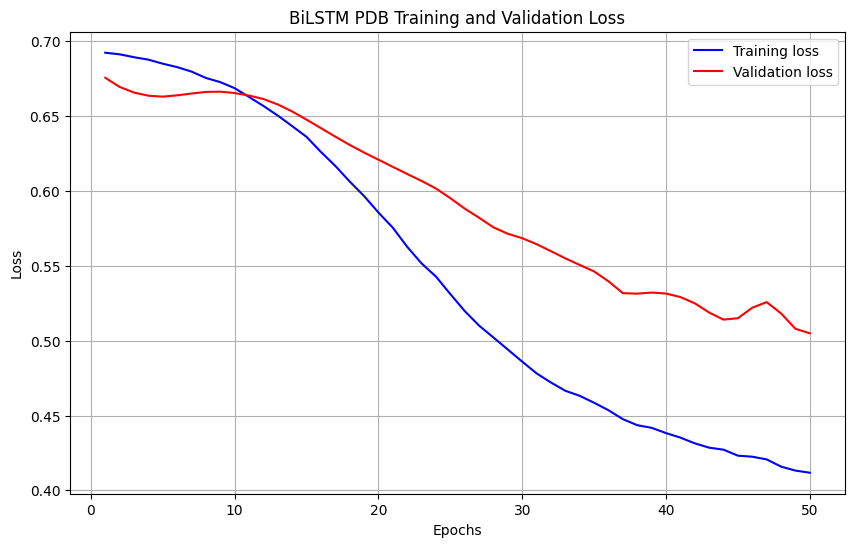

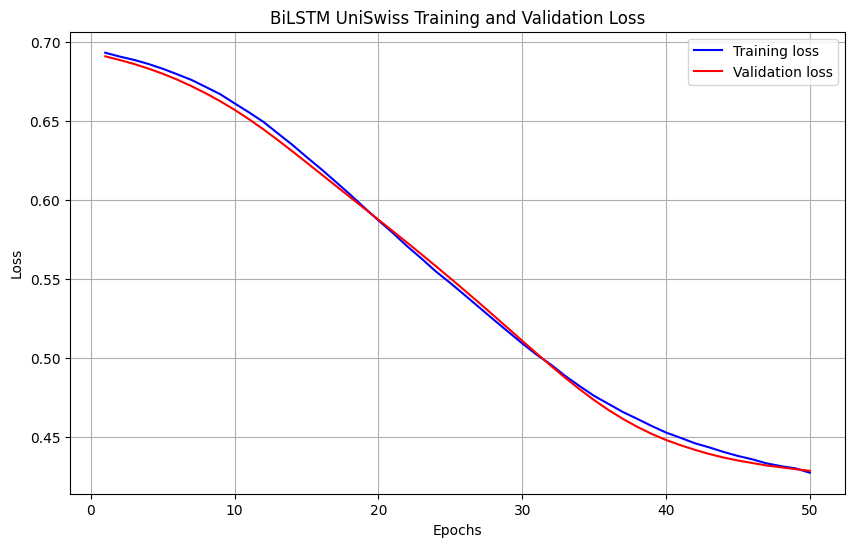

In [ ]:
plot_losses(pdb_train_losses, pdb_val_losses, 'BiLSTM PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'BiLSTM UniSwiss Training and Validation Loss')

###Machine Learning/MLP Only


Evaluation for MLP on PDB dataset:
Accuracy: 0.712 | Precision: 0.341 | Recall: 0.833 | F1: 0.484 | ROC_AUC: 0.862

Evaluation for MLP on UniSwiss dataset:
Accuracy: 0.786 | Precision: 0.798 | Recall: 0.760 | F1: 0.779 | ROC_AUC: 0.877


,Model,Dataset,Accuracy,Precision,Recall,Specificity,F1,MCC,ROC_AUC
0,MLP,PDB,0.711712,0.340909,0.833333,0.688172,0.483871,0.392982,0.862007
1,MLP,UniSwiss,0.785714,0.798319,0.760000,0.811024,0.778689,0.571889,0.876815


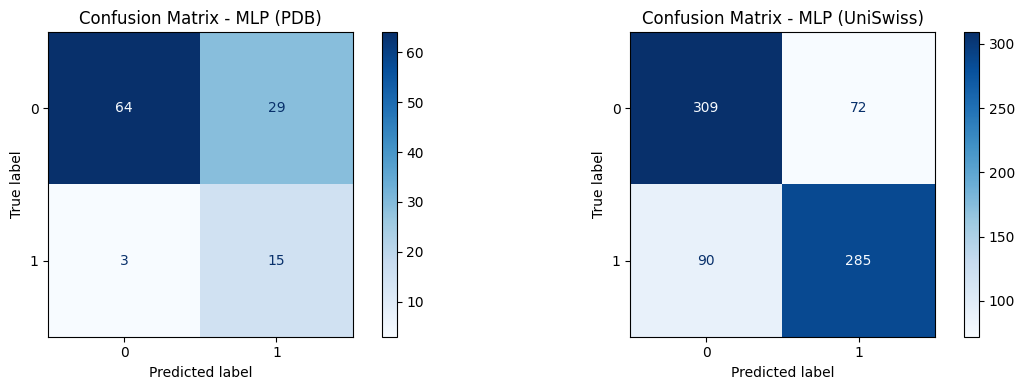

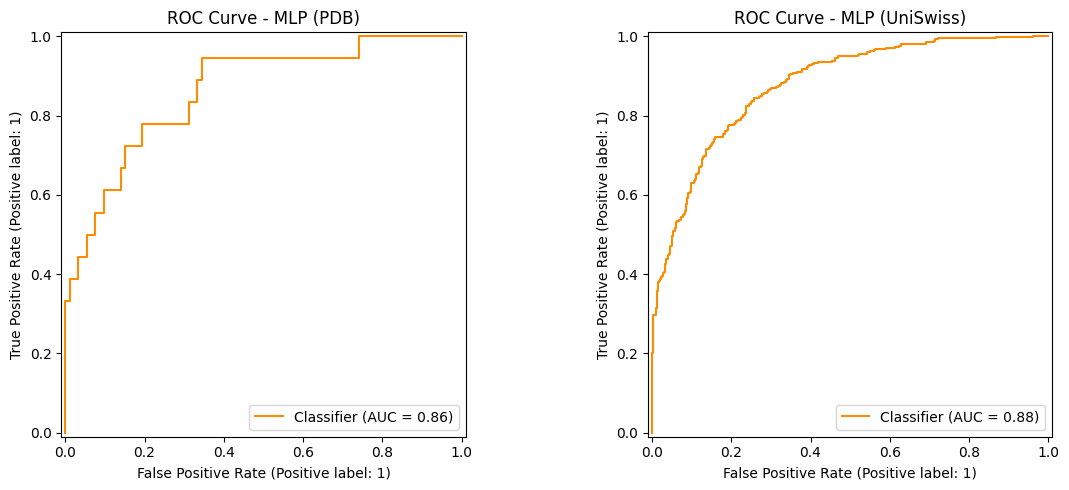

In [ ]:

# Evaluate PDB model
pdb_metrics, y_pred_pdb, y_prob_pdb = evaluate_model(
    trained_pdb_model_mlp, x_pdb_test_sel, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss model
uni_metrics, y_pred_uni, y_prob_uni = evaluate_model(
    trained_uni_model_mlp, x_uni_test_sel, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

results_df = pd.DataFrame([pdb_metrics, uni_metrics])
display(results_df)

visualize_metrics(
    y_pdb_test, y_pred_pdb, y_prob_pdb,
    y_uni_test, y_pred_uni, y_prob_uni,
    model_name="MLP"
)

### Plotting MLP Model Losses

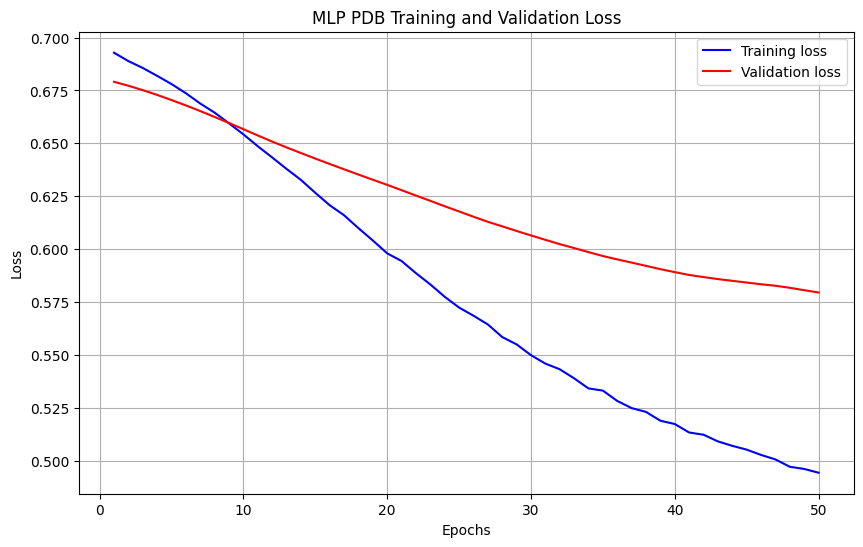

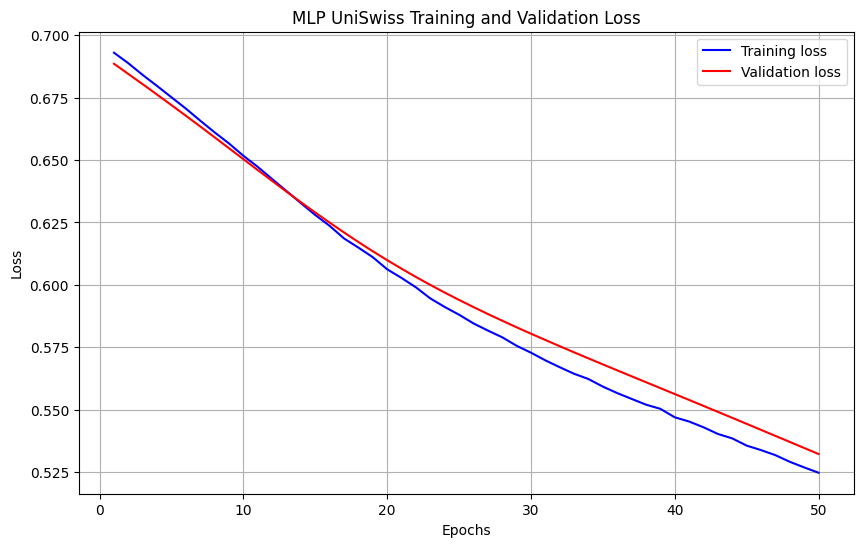

In [ ]:
plot_losses(pdb_mlp_train_losses, pdb_mlp_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_mlp_train_losses, uni_mlp_val_losses, 'MLP UniSwiss Training and Validation Loss')